In [18]:
import warnings

warnings.filterwarnings('ignore')

In [19]:
import pandas as pd
import numpy as np
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Plot Multiple Regime Methodologies in a Colorful Chart

In [25]:
def graph_regime_combo(ticker, df, _c, rg, lo, hi, slo, shi, clg, flr, rg_ch,
                       ma_st, ma_mt, ma_lt, lt_lo, lt_hi, st_lo, st_hi):
    '''
    https://www.color-hex.com/color-names.html
    ticker,df,_c: _c is closing price
    rg: regime -1/0/1 using floor/ceiling method
    lo,hi: small, noisy highs/lows
    slo,shi: swing lows/highs
    clg,flr: ceiling/floor

    rg_ch: regime change base
    ma_st,ma_mt,ma_lt: moving averages ST/MT/LT
    lt_lo,lt_hi: range breakout High/Low LT
    st_lo,st_hi: range breakout High/Low ST
    '''
    fig = plt.figure(figsize=(20, 8))
    ax1 = plt.subplot2grid((1, 1), (0, 0))
    date = df.index
    close = df[_c]
    ax1.plot_date(df.index, close, '-', color='k', label=ticker.upper())
    try:
        if pd.notnull(rg):
            base = df[rg_ch]
            regime = df[rg]

            if df[lo].count() > 0:
                ax1.plot(df.index, df[lo], '.', color='r', label='swing low', alpha=0.6)
            if df[hi].count() > 0:
                ax1.plot(df.index, df[hi], '.', color='g', label='swing high', alpha=0.6)
            if df[slo].count() > 0:
                ax1.plot(df.index, df[slo], 'o', color='r', label='swing low', alpha=0.8)
            if df[shi].count() > 0:
                ax1.plot(df.index, df[shi], 'o', color='g', label='swing high', alpha=0.8)
            if df[flr].count() > 0:
                plt.scatter(df.index, df[flr], c='k', marker='^', label='floor')
            if df[clg].count() > 0:
                plt.scatter(df.index, df[clg], c='k', marker='v', label='ceiling')

            ax1.plot([], [], linewidth=5, label='bear', color='m', alpha=0.1)
            ax1.plot([], [], linewidth=5, label='bull', color='b', alpha=0.1)
            ax1.fill_between(date, close, base, where=((regime == 1) & (close > base)), facecolor='b', alpha=0.1)
            ax1.fill_between(date, close, base, where=((regime == 1) & (close < base)), facecolor='b', alpha=0.4)
            ax1.fill_between(date, close, base, where=((regime == -1) & (close < base)), facecolor='m', alpha=0.1)
            ax1.fill_between(date, close, base, where=((regime == -1) & (close > base)), facecolor='m', alpha=0.4)

        if np.sum(ma_st) > 0:
            ax1.plot(df.index, ma_st, '-', color='lime', label='ST MA')
            ax1.plot(df.index, ma_mt, '-', color='green', label='MT MA')
            ax1.plot(df.index, ma_lt, '-', color='red', label='LT MA')

            if pd.notnull(rg):  # floor/ceiling regime present
                # Profitable conditions
                ax1.fill_between(date, close, ma_mt, where=((regime == 1) & (ma_mt >= ma_lt) & (ma_st >= ma_mt)),
                                 facecolor='green', alpha=0.5)
                ax1.fill_between(date, close, ma_mt, where=((regime == -1) & (ma_mt <= ma_lt) & (ma_st <= ma_mt)),
                                 facecolor='red', alpha=0.5)
                # Unprofitable conditions
                ax1.fill_between(date, close, ma_mt,
                                 where=((regime == 1) & (ma_mt >= ma_lt) & (ma_st >= ma_mt) & (close < ma_mt)),
                                 facecolor='darkgreen', alpha=1)
                ax1.fill_between(date, close, ma_mt,
                                 where=((regime == -1) & (ma_mt <= ma_lt) & (ma_st <= ma_mt) & (close >= ma_mt)),
                                 facecolor='darkred', alpha=1)

            elif pd.isnull(rg):  # floor/ceiling regime absent
                # Profitable conditions
                ax1.fill_between(date, close, ma_mt, where=((ma_mt >= ma_lt) & (ma_st >= ma_mt)),
                                 facecolor='green', alpha=0.4)
                ax1.fill_between(date, close, ma_mt, where=((ma_mt <= ma_lt) & (ma_st <= ma_mt)),
                                 facecolor='red', alpha=0.4)
                # Unprofitable conditions
                ax1.fill_between(date, close, ma_mt, where=((ma_mt >= ma_lt) & (ma_st >= ma_mt) & (close < ma_mt)),
                                 facecolor='darkgreen', alpha=1)
                ax1.fill_between(date, close, ma_mt, where=((ma_mt <= ma_lt) & (ma_st <= ma_mt) & (close >= ma_mt)),
                                 facecolor='darkred', alpha=1)

        if (np.sum(lt_hi) > 0):  # LT range breakout
            ax1.plot([], [], linewidth=5, label=' LT High', color='m', alpha=0.2)
            ax1.plot([], [], linewidth=5, label=' LT Low', color='b', alpha=0.2)

            if pd.notnull(rg):  # floor/ceiling regime present
                ax1.fill_between(date, close, lt_lo,
                                 where=((regime == 1) & (close > lt_lo)),
                                 facecolor='b', alpha=0.2)
                ax1.fill_between(date, close, lt_hi,
                                 where=((regime == -1) & (close < lt_hi)),
                                 facecolor='m', alpha=0.2)
                if (np.sum(st_hi) > 0):  # ST range breakout
                    ax1.fill_between(date, close, st_lo,
                                     where=((regime == 1) & (close > st_lo)),
                                     facecolor='b', alpha=0.3)
                    ax1.fill_between(date, close, st_hi,
                                     where=((regime == -1) & (close < st_hi)),
                                     facecolor='m', alpha=0.3)

            elif pd.isnull(rg):  # floor/ceiling regime absent
                ax1.fill_between(date, close, lt_lo,
                                 where=((close > lt_lo)), facecolor='b', alpha=0.2)
                ax1.fill_between(date, close, lt_hi,
                                 where=((close < lt_hi)), facecolor='m', alpha=0.2)
                if (np.sum(st_hi) > 0):  # ST range breakout
                    ax1.fill_between(date, close, st_lo,
                                     where=((close > st_lo) & (st_lo >= lt_lo)), facecolor='b', alpha=0.3)
                    ax1.fill_between(date, close, st_hi,
                                     where=((close < st_hi) & (st_hi <= lt_hi)), facecolor='m', alpha=0.3)

            if (np.sum(st_hi) > 0):  # ST range breakout
                ax1.plot([], [], linewidth=5, label=' ST High', color='m', alpha=0.3)
                ax1.plot([], [], linewidth=5, label=' ST Low', color='b', alpha=0.3)

            ax1.plot(df.index, lt_lo, '-.', color='b', label='LT low', alpha=0.2)
            ax1.plot(df.index, lt_hi, '-.', color='m', label='LT high', alpha=0.2)
    except:
        pass

    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.grid(True)
    ax1.xaxis.label.set_color('k')
    ax1.yaxis.label.set_color('k')
    plt.xlabel('Date')
    plt.ylabel(str.upper(ticker) + ' Price')
    plt.title(str.upper(ticker))
    plt.legend()


# Range Breakout Regime Methodology

[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': '9984.T 252 days high/low'}, xlabel='Date'>

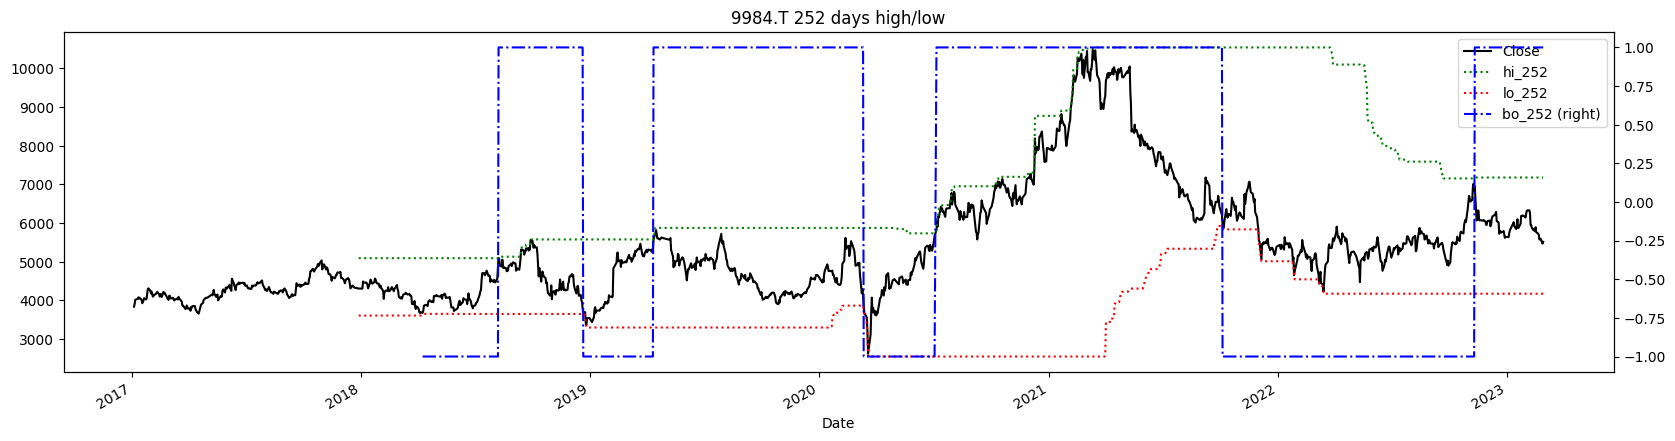

In [21]:
def regime_breakout(df, _h, _l, window):
    hl = np.where(df[_h] == df[_h].rolling(window).max(), 1,
                  np.where(df[_l] == df[_l].rolling(window).min(), -1, np.nan))
    roll_hl = pd.Series(index=df.index, data=hl).fillna(method='ffill')
    return roll_hl


ticker = '9984.T'  # Softbank
start = '2016-12-31'
end = None
df = yf.download(tickers=ticker, start=start, end=end, interval="1d",
                 group_by='column', auto_adjust=True, prepost=True,
                 threads=True, proxy=None)

window = 252
df['hi_' + str(window)] = df['High'].rolling(window).max()
df['lo_' + str(window)] = df['Low'].rolling(window).min()
df['bo_' + str(window)] = regime_breakout(df=df, _h='High', _l='Low', window=window)
df[['Close', 'hi_' + str(window), 'lo_' + str(window), 'bo_' + str(window)]].plot(secondary_y=['bo_' + str(window)],
                                                                                  figsize=(20, 5),
                                                                                  style=['k', 'g:', 'r:', 'b-.'],
                                                                                  title=str.upper(ticker) + ' ' + str(
                                                                                      window) + ' days high/low')

# Utilities Functions

In [22]:
def lower_upper_OHLC(df, relative=False):
    if relative == True:
        rel = 'r'
    else:
        rel = ''
    if 'Open' in df.columns:
        ohlc = [rel + 'Open', rel + 'High', rel + 'Low', rel + 'Close']
    elif 'open' in df.columns:
        ohlc = [rel + 'open', rel + 'high', rel + 'low', rel + 'close']

    try:
        _o, _h, _l, _c = [ohlc[h] for h in range(len(ohlc))]
    except:
        _o = _h = _l = _c = np.nan
    return _o, _h, _l, _c


def regime_args(df, lvl, relative=False):
    if ('Low' in df.columns) & (relative == False):
        reg_val = ['Lo1', 'Hi1', 'Lo' + str(lvl), 'Hi' + str(lvl), 'rg', 'clg', 'flr', 'rg_ch']
    elif ('low' in df.columns) & (relative == False):
        reg_val = ['lo1', 'hi1', 'lo' + str(lvl), 'hi' + str(lvl), 'rg', 'clg', 'flr', 'rg_ch']
    elif ('Low' in df.columns) & (relative == True):
        reg_val = ['rL1', 'rH1', 'rL' + str(lvl), 'rH' + str(lvl), 'rrg', 'rclg', 'rflr', 'rrg_ch']
    elif ('low' in df.columns) & (relative == True):
        reg_val = ['rl1', 'rh1', 'rl' + str(lvl), 'rh' + str(lvl), 'rrg', 'rclg', 'rflr', 'rrg_ch']

    try:
        rt_lo, rt_hi, slo, shi, rg, clg, flr, rg_ch = [reg_val[s] for s in range(len(reg_val))]
    except:
        rt_lo = rt_hi = slo = shi = rg = clg = flr = rg_ch = np.nan
    return rt_lo, rt_hi, slo, shi, rg, clg, flr, rg_ch

# Turtle Trading

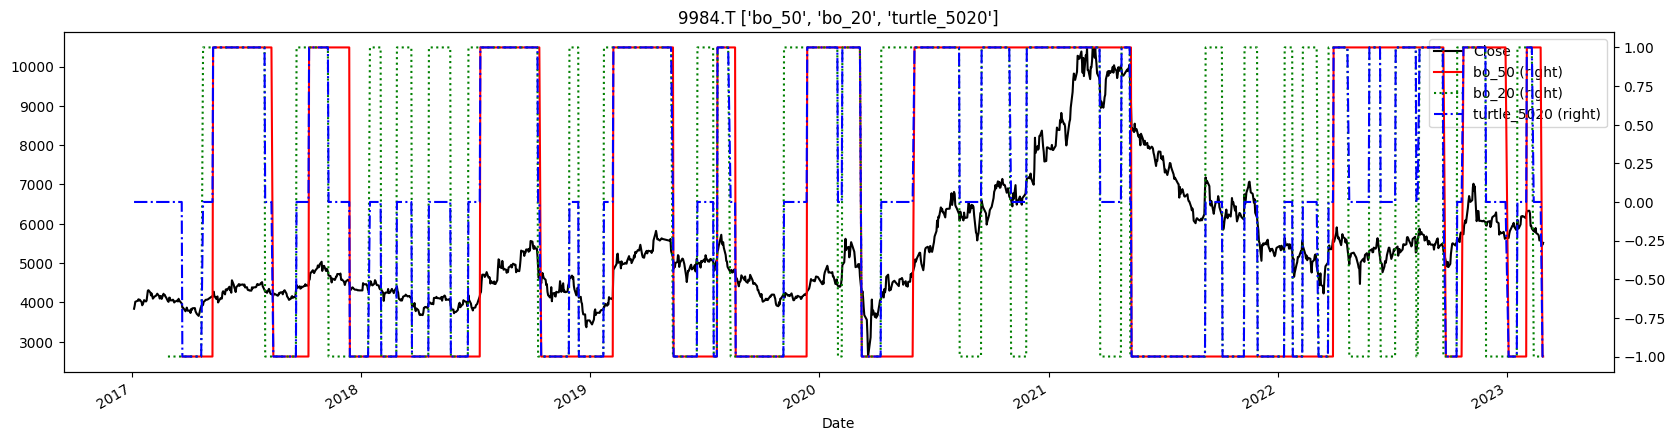

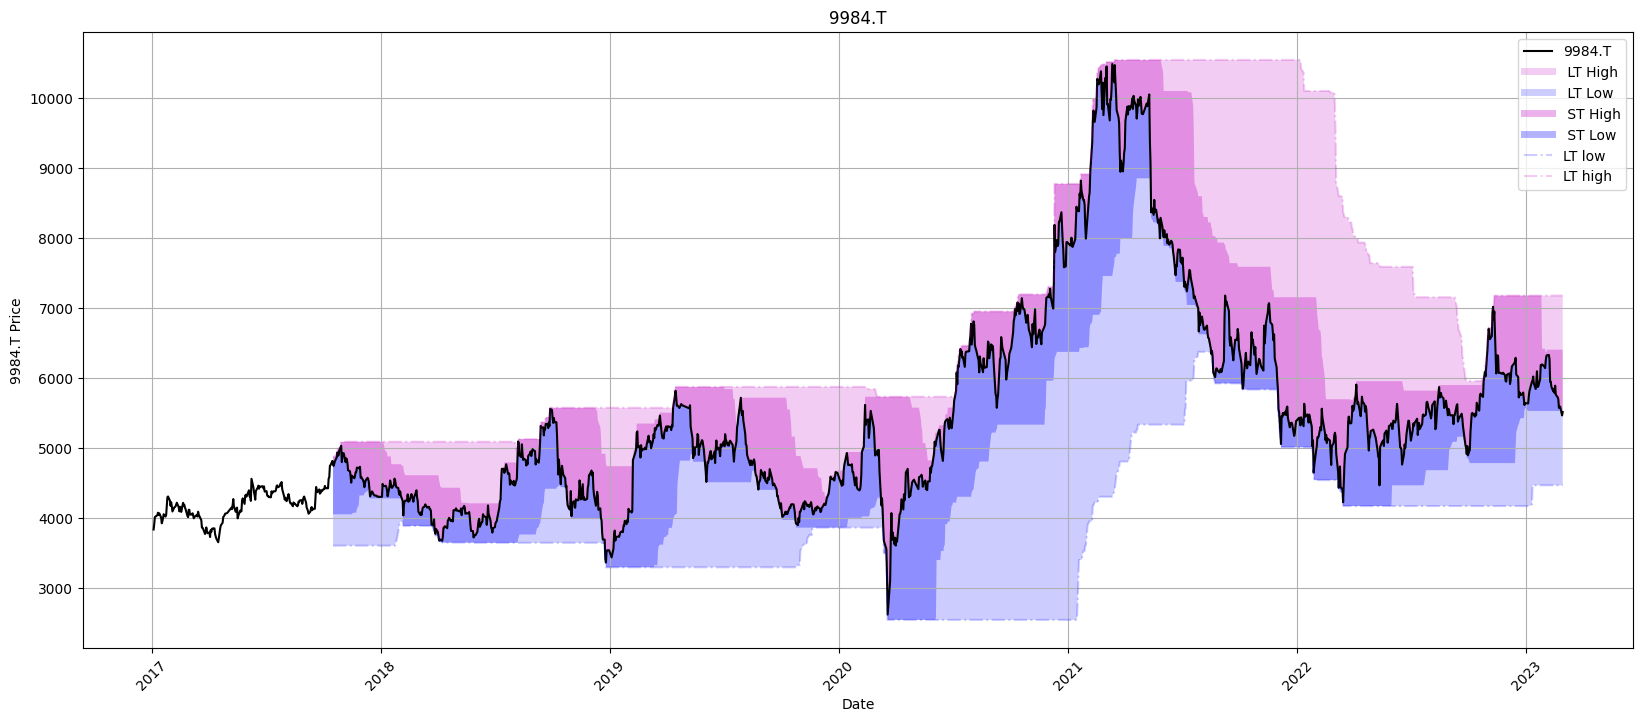

In [23]:
def turtle_trader(df, _h, _l, slow, fast):
    '''
    _slow: Long/Short direction
    _fast: trailing stop loss
    '''
    _slow = regime_breakout(df, _h, _l, window=slow)
    _fast = regime_breakout(df, _h, _l, window=fast)
    turtle = pd.Series(index=df.index,
                       data=np.where(_slow == 1, np.where(_fast == 1, 1, 0),
                                     np.where(_slow == -1, np.where(_fast == -1, -1, 0), 0)))
    return turtle


_o, _h, _l, _c = lower_upper_OHLC(df, relative=False)

fast = 20
slow = 50

df['bo_' + str(slow)] = regime_breakout(df, _h, _l, window=slow)
df['bo_' + str(fast)] = regime_breakout(df, _h, _l, window=fast)
df['turtle_' + str(slow) + str(fast)] = turtle_trader(df, _h, _l, slow, fast)
rg_cols = ['bo_' + str(slow), 'bo_' + str(fast), 'turtle_' + str(slow) + str(fast)]

df[['Close', 'bo_' + str(slow), 'bo_' + str(fast), 'turtle_' + str(slow) + str(fast)]].plot(
    secondary_y=rg_cols, figsize=(20, 5), style=['k', 'r', 'g:', 'b-.'],
    title=str.upper(ticker) + ' ' + str(rg_cols))

_o, _h, _l, _c = lower_upper_OHLC(df, relative=False)

ma_st = ma_mt = ma_lt = 0
rg = lo = hi = slo = shi = clg = flr = rg_ch = None

bo = [50, 200]
st_lo, lt_lo = [df[_l].rolling(window=bo[t]).min() for t in range(len(bo))]
st_hi, lt_hi = [df[_h].rolling(window=bo[t]).max() for t in range(len(bo))]

graph_regime_combo(ticker, df, _c, rg, lo, hi, slo, shi, clg, flr, rg_ch, ma_st, ma_mt, ma_lt, lt_lo, lt_hi, st_lo,
                   st_hi)